In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling


image 1/1 /content/k2.png: 640x640 18 bottles, 69.7ms
Speed: 3.3ms preprocess, 69.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/k2.png: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 157.0ms
Speed: 7.1ms preprocess, 157.0ms inference, 2.8ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs/segment/predict3


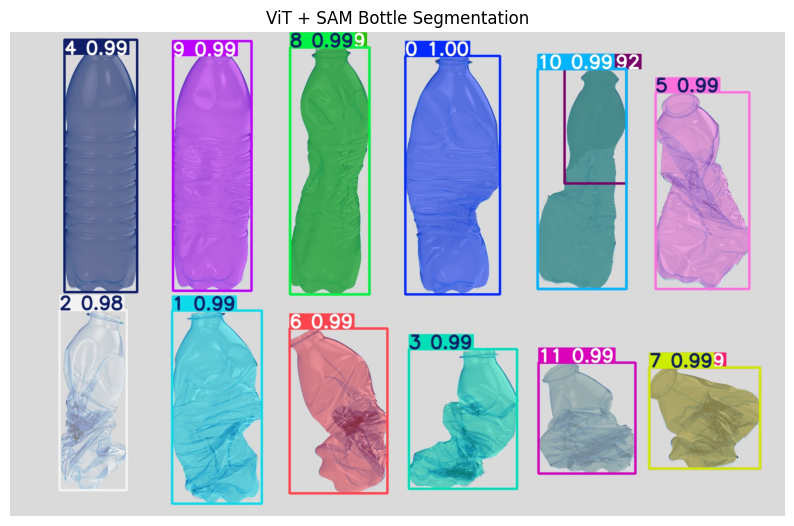

In [5]:
import cv2
import matplotlib.pyplot as plt
import os
import glob
from ultralytics import RTDETR, SAM

# Load models
model = RTDETR("ViT.pt")
sam_model = SAM("mobile_sam.pt")

# Input image path
image_path = "k2.png"

# Run object detection
results = model(image_path)

# Filter only 'bottle' class (class ID = 0)
bottle_class_id = 0
bottle_boxes = []
for r in results:
    for box, cls in zip(r.boxes.xyxy, r.boxes.cls):
        if int(cls) == bottle_class_id:
            bottle_boxes.append(box.tolist())

# Run SAM
if bottle_boxes:
    sam_model.predict(
        image_path,
        bboxes=bottle_boxes,
        save=True
    )

    # Find the most recent SAM output folder
    segment_dirs = sorted(glob.glob("runs/segment/predict*"), key=os.path.getmtime)
    if segment_dirs:
        latest_dir = segment_dirs[-1]

        # Match image file regardless of extension
        base_name_no_ext = os.path.splitext(os.path.basename(image_path))[0]
        matched_files = glob.glob(os.path.join(latest_dir, f"{base_name_no_ext}.*"))

        if matched_files:
            output_img_path = matched_files[0]
            segmented_image = cv2.imread(output_img_path)
            segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(10, 8))
            plt.imshow(segmented_image_rgb)
            plt.axis('off')
            plt.title("ViT + SAM Bottle Segmentation")
            plt.show()
        else:
            print(f"❌ No output image matching {base_name_no_ext}.* found in {latest_dir}")
    else:
        print("❌ No SAM output directories found.")
else:
    print("No bottles detected.")
